# Learning Objectives

1. Understand the API structure of prompts presented to LLMs and the parameters available to control generation.

2. Implement key prompt engineering patterns, that is, few-shot, chain-of-thought, rephrase & respond, self-consistency, tree-of-thought & LLM-as-a-judge.





# Setup

Azure provides seamless integration with the OpenAI API to provide access to the GPT-series of models.

In [1]:
# !pip install -q openai==1.23.2
%load_ext dotenv
%dotenv

## Authentication

To enable API access at scale, we will need to authorize our compute infrastructure (in this case the Colab notebook) to programmatically access Azure APIs. This authentication is managed by storing the API secret keys within the secrets tab of Colab (see the steps below).

Paste your Azure API key in the secrets tab in the left panel.

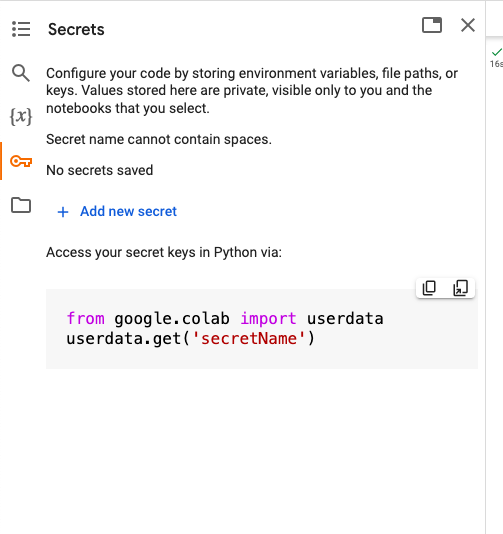

Ensure that you enable notebook access

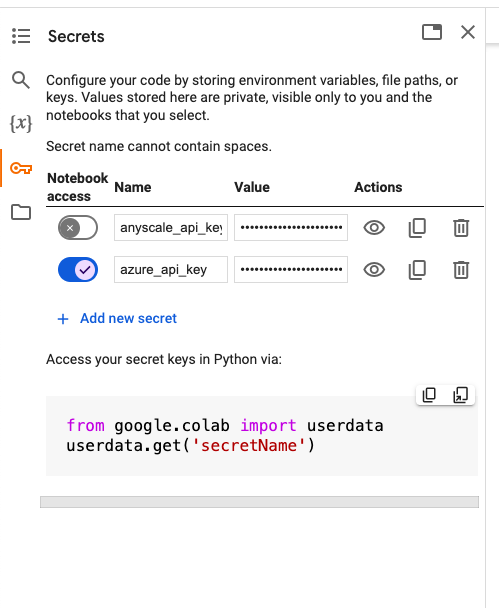

Note that this is a one time exercise, and the API key will be available across all your Colab notebooks linked to the Google account.

In [2]:
from openai import AzureOpenAI
import os


Now we can read the API key from Colab secrets. This way we do not expose our API keys in a notebook.

In [3]:
azure_api_key = os.getenv('azure_api_key')
azure_api_endpoint  = os.getenv('azure_endpoint')

With authentication in place, we can now instantiate a client that will access models hosted on Azure and exposed to us as APIs. You will need to retrieve the key and the endpoint that was created earlier from either the Azure portal or the Playground (click on View Code).

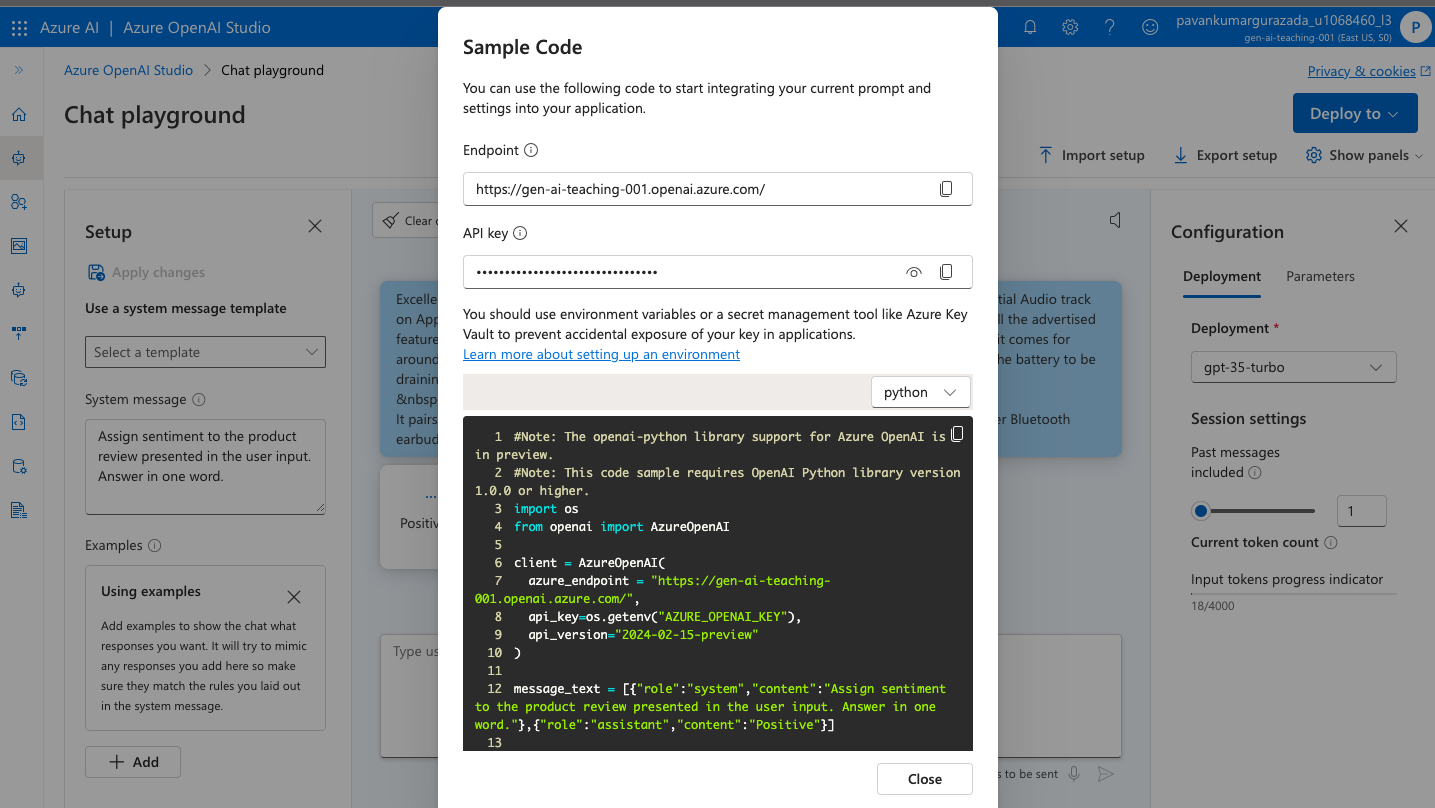

In [4]:
client = AzureOpenAI(
  azure_endpoint = azure_api_endpoint,
  api_key=azure_api_key,
  api_version="2024-02-01"
)

In [5]:
model_name = 'gpt-35-turbo' # deployment name

# Prompt Structure

Prompts presented to the Azure Open AI API for inference have to follow a specific structure with three roles - `system`, `user` and `assistant`.

These roles are:

- `system`: A set of instructions to be followed by the LLM as defined by the application developer
- `user`: A placeholder for users (i.e., users of the application) to present their input
- `assistant`: Response from the LLM where the system message is applied to the user input.

LLMs are tuned to understand sets of instructions as defined by these roles. LLM APIs provide a mechanism to encapsulate the *constant* portion of these instructions as the *system prompt*. While it is is optional, when a system prompt (e.g., "Classify the sentiment of the input sentence. Do not answer any other question") is mentioned, it is automatically pasted ahead of all the instructions entered by the user without us needing to explictly append it with every instruction.

System messages are a great way to restrict the behaviour of the LLM to a specific, controlled set of instructions. Since end-users of the application have no access to the system message (system message can be edited by only the application developer), there is very less chance of the application being hijacked beyond its intended purpose.

The `user` and `assistant` roles enable:
- multi-turn conversations
- showcasing ideal responses expected from the model

A typical prompt structure is presented in the figure below.


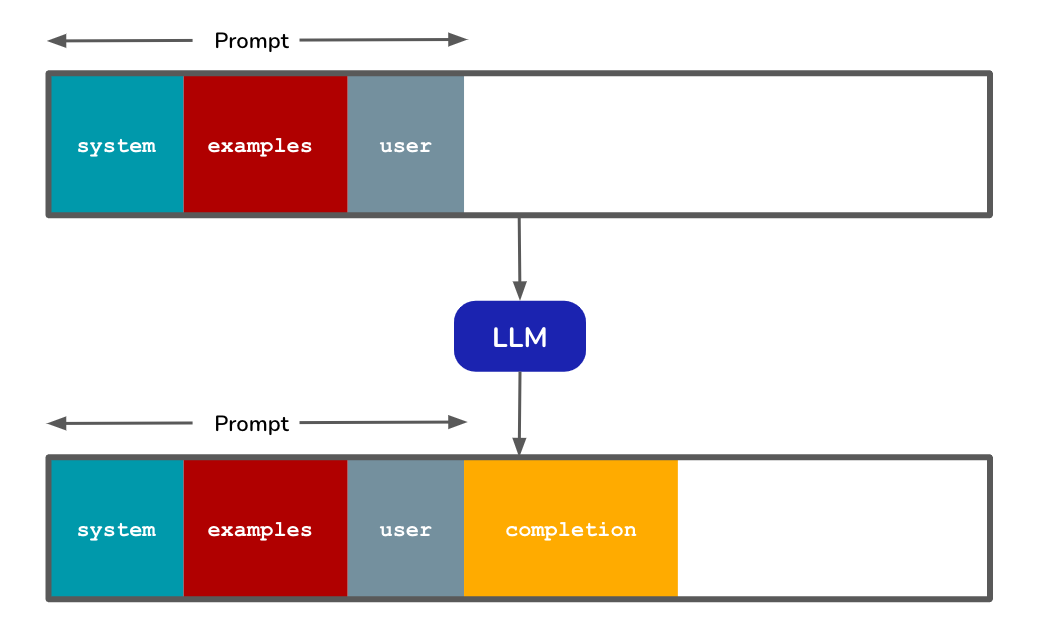

Each example is a pair of `user` and `assistant` messages that illustrates expected output from the LLM.

Let us see these roles in action.

In [6]:
system_message = """
You are a loan approval application, to determine whether the loan should be approved or not. The business logic will follow a series of checks and calculations to ensure responsible lending based on risk factors like income, credit score, and family responsibilities. Approach as below:
Business Logic for Loan Approval:
1. Eligibility Verification (Initial Checks)
Before proceeding with risk assessment, we ensure that all necessary customer details are provided and meet basic eligibility criteria:
•	Income: Ensure that income is provided (either monthly or annually).
•	Credit Score: Ensure the credit score is a valid number (typically between 300 and 850).
•	Family Members: Ensure the number of family members is provided (must be a positive integer).
•	Employment Status: Ensure that employment status is provided (employed/self-employed/unemployed).
•	Loan Amount: Ensure the loan amount requested is specified.
•	Outstanding Debts: If provided, these should be accounted for in assessing the customer’s financial obligations.
If any of these details are missing or invalid, do not proceed further and the application should return "Not Approved" with an explanation like "Missing or invalid customer details."
2. Risk Assessment Score Calculation
Once the necessary details are verified, we calculate a Risk Score based on three main factors: Credit Score, Income Stability, and Family Responsibilities.
•	Credit Score (Weight: 50%):
o	Score Range:
	720+ (Excellent) = 5 points
	680–719 (Good) = 4 points
	640–679 (Fair) = 3 points
	600–639 (Poor) = 2 points
	Below 600 (Very Poor) = 1 point
o	The higher the credit score, the more favourable it is for approval.
•	Income Stability (Weight: 30%):
o	Income is evaluated based on how well it can cover the loan request, existing debt, and family needs. Use the Debt-to-Income Ratio (DTI), calculated as: DTI=Total Monthly Debt Payments (incl. loan)Monthly Income×100\text{DTI} = \frac{\text{Total Monthly Debt Payments (incl. loan)} }{\text{Monthly Income}} \times 100DTI=Monthly IncomeTotal Monthly Debt Payments (incl. loan)×100
	DTI < 35% (Low Risk) = 5 points
	DTI 35%–49% (Moderate Risk) = 3 points
	DTI ≥ 50% (High Risk) = 1 point
o	Lower DTI suggests a higher ability to repay the loan.
•	Family Responsibilities (Weight: 20%):
o	The number of dependents impacts financial obligations. More dependents may reduce disposable income.
	0–1 dependents = 5 points
	2–3 dependents = 3 points
	4+ dependents = 1 point
3. Decision Based on Risk Score
Combine the scores from each factor and calculate the total Risk Score. The maximum possible score is 5 (Credit Score) + 5 (Income) + 5 (Family) = 15 points.
•	Approval Threshold:
o	Approved: Risk Score ≥ 10
o	Not Approved: Risk Score < 10
4. Detailed Decision Output
If any of these input details are missing or invalid, do not proceed further and the application should return "Not Approved" with an explanation like "Missing or invalid customer details."
•	Approved: "Your loan has been approved based on your strong credit score, manageable debt-to-income ratio, and household size."
•	Not Approved: Specific reasons for rejection should be provided, such as:
o	"Your loan application was not approved due to a low credit score."
o	"Your debt-to-income ratio exceeds the acceptable threshold, indicating a high risk."
o	"Your family responsibilities and existing debts reduce your disposable income."
"""

In [10]:
user_input = """
Customer with Strong Profile
•	Income: $6,000/month
•	Credit Score: 750
•	Family Members: 2
•	Outstanding Debt: $1,200
•	Loan Request: $25,000 (Monthly payments: $500)
•	Employment Status: self-employed
"""

In [11]:
response = client.chat.completions.create(
    model=model_name,
    messages=[
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_input}
    ]
)

In [12]:
print(response.choices[0].message.content)

Based on the provided information, let's evaluate the loan application for the customer with a strong profile.

Eligibility Verification:
- Income is provided: $6,000/month
- Credit Score is provided: 750
- Family Members are provided: 2
- Employment Status is provided: self-employed
- Loan Amount is specified: $25,000
- Outstanding Debts are provided: $1,200

All the necessary customer details are provided and meet the basic eligibility criteria.

Risk Assessment Score Calculation:
1. Credit Score (Weight: 50%): 
   The credit score of 750 falls under the "Good" category, which awards 4 points.

2. Income Stability (Weight: 30%):
   DTI = (Total Monthly Debt Payments (incl. loan) / Monthly Income) * 100
   Monthly Debt Payments (incl. loan) = $1,200 + $500 = $1,700
   DTI = ($1,700 / $6,000) * 100 = 28.33%

   Since the DTI is less than 35%, it falls under the "Low Risk" category, which awards 5 points.

3. Family Responsibilities (Weight: 20%):
   The customer has 2 dependents, which

In [13]:
user_inputa = """
•	Income: $4,000/month
•	Credit Score: 620
•	Family Members: 4
•	Outstanding Debt: $1,800
•	Loan Request: $15,000 (Monthly payments: $400)
•	Employment Status: employed
"""

In [14]:
response = client.chat.completions.create(
    model=model_name,
    messages=[
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_inputa}
    ]
)

In [15]:
print(response.choices[0].message.content)

Based on the provided details, let's evaluate the loan application for approval:

1. Eligibility Verification:
   - Income: Provided ($4,000/month) - Valid.
   - Credit Score: Provided (620) - Valid.
   - Family Members: Provided (4) - Valid.
   - Employment Status: Provided (employed) - Valid.
   - Loan Amount: Provided ($15,000) - Valid.
   - Outstanding Debts: Provided ($1,800) - Valid.

2. Risk Assessment Score Calculation:
   - Credit Score: 2 points (Fair).
   - Income Stability:
     - Monthly Debt Payments (incl. loan): $2,200 (loan payment + outstanding debts).
     - Monthly Income: $4,000.
     - DTI = (2,200 / 4,000) * 100 = 55% - High Risk (1 point).
   - Family Responsibilities: 1 point (4+ dependents).

3. Decision Based on Risk Score:
   - Total Risk Score: 2 (Credit Score) + 1 (Income Stability) + 1 (Family Responsibilities) = 4 points.

4. Detailed Decision Output:
   - Not Approved: Based on the risk score of 4, your loan application has not been approved.
   - Rejec